In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy.optimize as optim
from scipy import stats
import cvxpy as cp
from tqdm import tqdm
import json
from multiprocessing.pool import Pool
import os
import sys
import seaborn as sns
import pandas as pd
sys.path.append('..')

from src.samplers.importance_sampler import *
from src.samplers.utils import check_feasibility_out_of_sample
from src.samplers import preprocessing as pre
from src.data_utils import synthetic as synth
from src.data_utils import plotting
from src.data_utils import snapshots as ss
from src.solvers import scenario_approx as SA
from src.solvers import utils as SU
from src.solvers import analytical_approx as AA
from src.samplers import utils as sampling

font = {'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

# Assuming initial Gaussians to be distributed non-standardly
## Standartize first

In [2]:
mu = np.ones(2)
Sigma = np.array([[1, 0], [0, 1]]) * 0.1
# making matrix psd
Sigma = Sigma.dot(Sigma.T)
J = 7
tau = 10
Gamma, Beta = synth.regular_polyhedron(J, tau)
#A = Gamma
Gamma, Beta, A = pre.standartize(Gamma, Beta, mu, Sigma)
c = np.array([-1, 1, 0, 0])

In [3]:
xs = np.linspace(-15, 15, 250)
ys = np.linspace(-15, 15, 250)
XX, YY = np.meshgrid(xs, ys)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


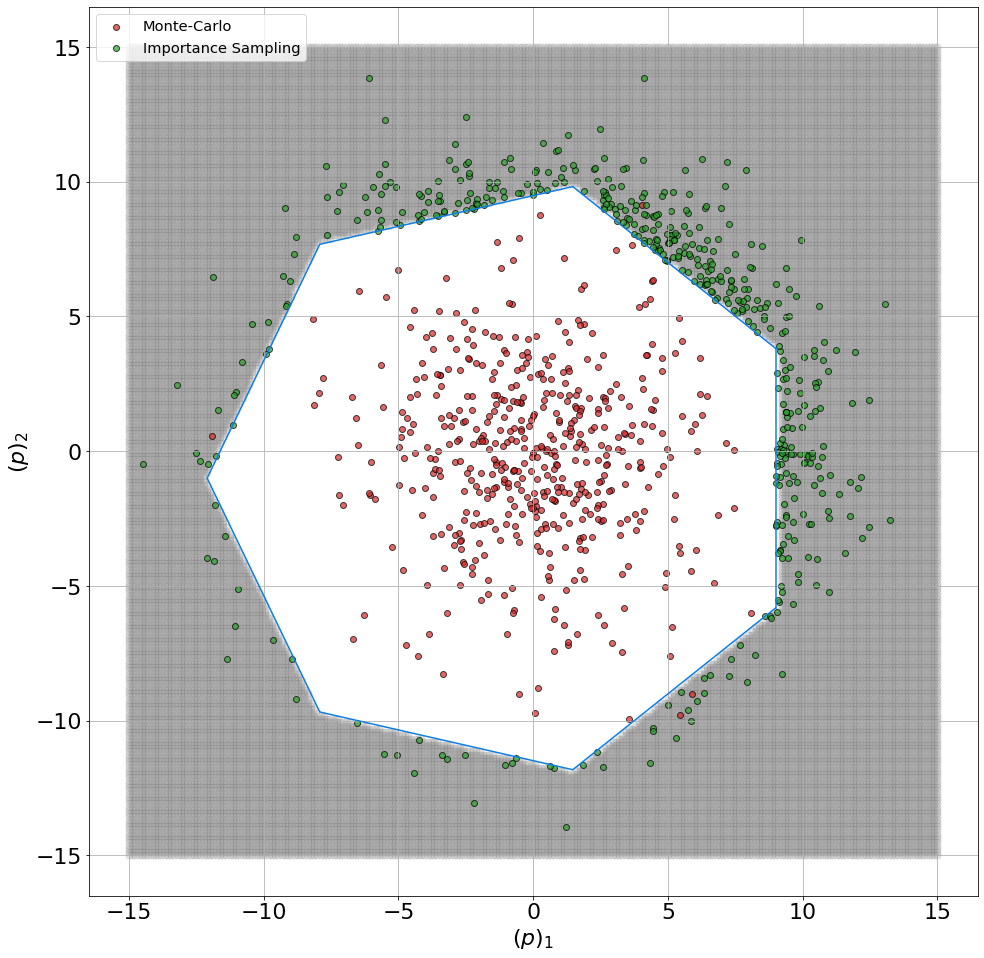

In [100]:
t = 0
normal_samples = np.random.multivariate_normal(np.zeros(2), np.eye(2)*10, 500)
import_samples = np.random.multivariate_normal(np.zeros(2), np.eye(2)*10, 60000)
import_samples = import_samples[(((Gamma @ import_samples.T).T - Beta.reshape(1, -1)) > 0).any(axis=1), :]
plt.figure(figsize=(14, 14))
for i in range(len(xs)):
    idxs = (((Gamma @ np.array([xs[i] * np.ones(len(ys)), ys])).T - Beta.reshape(1, -1)) > (0 + 1)).any(axis=1)
    plt.scatter((xs[i] * np.ones(len(ys)))[idxs], ys[idxs], alpha=0.2, s=50, color='grey')
plotting.plot_polygon(Gamma, Beta, label=None, xmin=-200, xmax=200)
plt.scatter(x=normal_samples[:, 0], y=normal_samples[:, 1], color='C3', alpha=0.7, edgecolors='black', label='Monte-Carlo')
plt.scatter(x=import_samples[:, 0], y=import_samples[:, 1], color='C2', alpha=0.7, edgecolors='black',label='Importance Sampling')



plt.grid()
plt.legend(prop={"size": font['size']/1.5}, loc="upper left")
plt.xlabel(r'$(p)_1$')
plt.ylabel(r'$(p)_2$')
plt.tight_layout()
plt.savefig('../saves/conditioned_vs_MC (1).jpg')

# plotting.plot_polygon(A_snapshots[t], np.ones(J) * (Phi_inv), label='A xi <= Phi^-1(eta)', xmin=-200, xmax=200, color_idx=2)
# plotting.plot_polygon(A_snapshots[t], Beta_P_snapshots[t], label='step0 for xi', color_idx=4, xmin=-200, xmax=200)

In [4]:
eta = 0.05

# Consider a signle sample $\xi_1 \sim \mathcal{N}(0, 1)$
The polytopes for $i=1, \dots, \mathcal{T}$ will be
$$
A \left( \frac{x_0}{|P_g| \cdot i} + \xi \cdot \alpha \right) \leq \frac{b}{|P_g| \cdot i}
$$
Let us see what does it look like for some realization $\xi_1, \xi_2, \xi_3$ and $\alpha = \left(0.5, 0.5\right)^T.$ Here we assume planning horizon of $\mathcal{T}$ steps.

In [5]:
T = 3
alphas = np.array([0.5, 0.5])
Gamma_s, Beta_s, Aalpha = ss.get_snapshots_planes(
        Gamma, Beta, np.ones((T, Gamma.shape[1])), alphas, T
    )

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


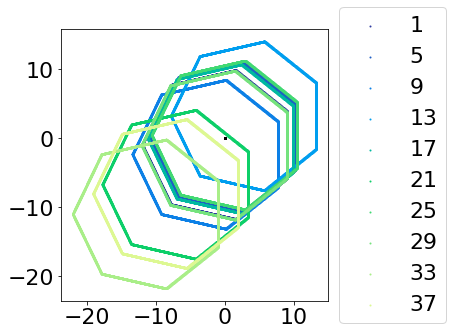

In [6]:
plotting.plot_polygon_multistep_AGC(Gamma, Beta, alphas=np.array([0.5, 0.5]), T=80, up_to_T=40, xmin=-100, xmax=100)

In [7]:
alpha_0 = np.array([0.5, 0.5])
mu = np.zeros(2)
Sigma = np.diag(alpha_0 ** 2)#np.array([[1, 0], [0, 1]]) * 0.1
Sigma
J = 5
tau = 30
Gamma, Beta = synth.regular_polyhedron(J, tau) # base polyhedron
c = np.array([-1, 1, 0, 0])

T = 3 # time snapshots
Gamma_snapshots = []
Beta_snapshots = []
A_snapshots = []
Beta_P_snapshots = []
# Gamma_s, Beta_s, _ = ss.get_snapshots_planes(
#         Gamma, Beta, np.ones((T, Gamma.shape[1])), None, T
#     )
sigmas_sq = np.ones((T, Gamma.shape[1])) * 1
kappa_t = sigmas_sq.cumsum()[Gamma.shape[1] - 1 :][
        ::Gamma.shape[1]
    ]  # equivalent to np.array([sigmas[:i, :] for i in range(T)])
# assert np.allclose(chi_t, np.array([sigmas_sq[:i, :] for i in range(1,T)]))
t_factors = np.sqrt(kappa_t)
for t in range(T):
    Sigma = np.diag(alpha_0 ** 2)
    Sigma = Sigma * t_factors[t]
    Gamma_snapshot, Beta_snapshot, A_snapshot = pre.standartize(Gamma, Beta, mu, Sigma, standartize_ineqs=True)
    Gamma_snapshots.append(Gamma_snapshot)
    Beta_snapshots.append(Beta_snapshot)
    A_snapshots.append(A_snapshot)
    Phi_inv = stats.norm.ppf(1-eta)
    Beta_P = +np.ones(J) * (-Phi_inv) + Beta_snapshot
    Beta_P_snapshots.append(Beta_P)
    


In [23]:
stats.norm.ppf(1-eta) * 1 * (Gamma_snapshots[t].dot([5, 3]))

array([ 13.83151519,  12.16690484,  -6.31195446, -16.06790723,
        -3.61855834])

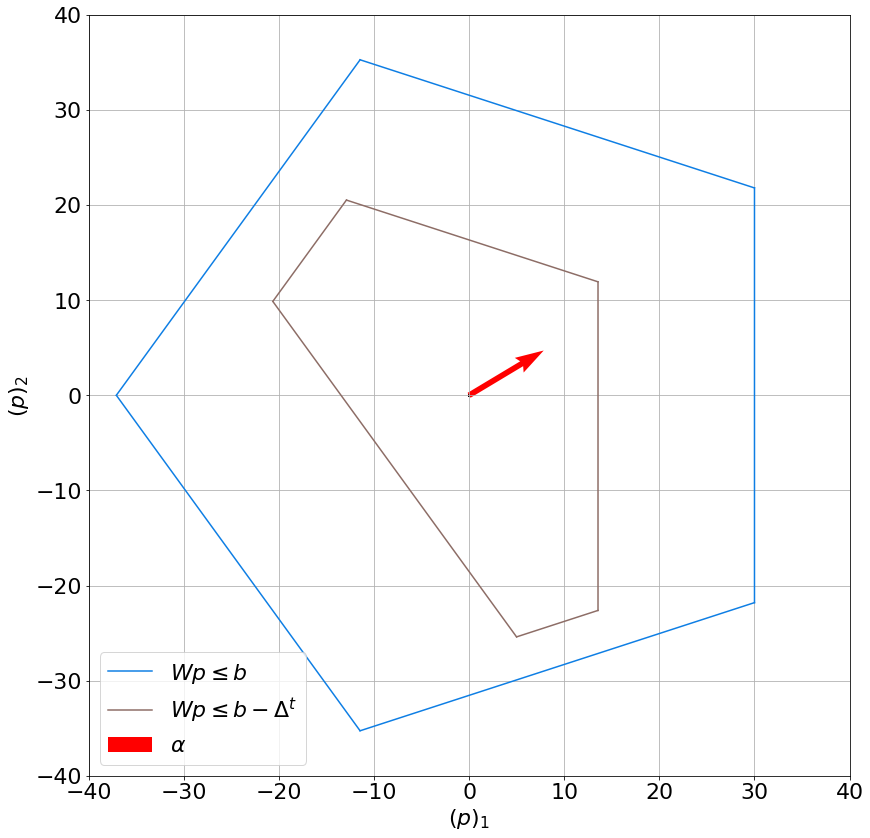

In [34]:
x = np.array([0, 50, 50])
y = np.array([0, 50000, 50000])
def plot_necessary(ax1, sigma_=1, ax_i=1):
    V = np.array([[5,3], ])
    plotting.plot_polygon(Gamma_snapshots[t], Beta_snapshots[t], label=r'$Wp \leq b$', xmin=-200, xmax=200, ax=ax1)
    plotting.plot_polygon(Gamma_snapshots[t], Beta_snapshots[t] - stats.norm.ppf(1-eta) * 2 *sigma_ * np.abs(Gamma_snapshots[t].dot(V[0])), label=r'$Wp \leq b - \Delta^t$', xmin=-200, xmax=200, ax=ax1, color_idx=7)



    
    origin = np.array([[0],[0]]) # origin point

    
    np.random.seed(112)
    # normal_samples = np.random.randn(50) * 1 * sigma_
    
    # ax1.scatter(V[0][0] * normal_samples, V[0][1] * normal_samples, color='C4', alpha=0.7, edgecolors='black', label='Possible AGC recourse')
    ax1.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=51, label=r'$\alpha$')
    ax1.set_xlim((-40, 40))
    ax1.set_ylim((-40, 40))
    ax1.grid()
    
    
    ax1.set_xlabel(r'$(p)_1$')
    ax1.set_ylabel(r'$(p)_2$')

    # ax1.tight_layout()
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plot_necessary(ax, sigma_=1, ax_i=0)
plt.legend(prop={"size": font['size']}, loc="lower left")
plt.savefig('../saves/necassary_poly.png')
plt.show()

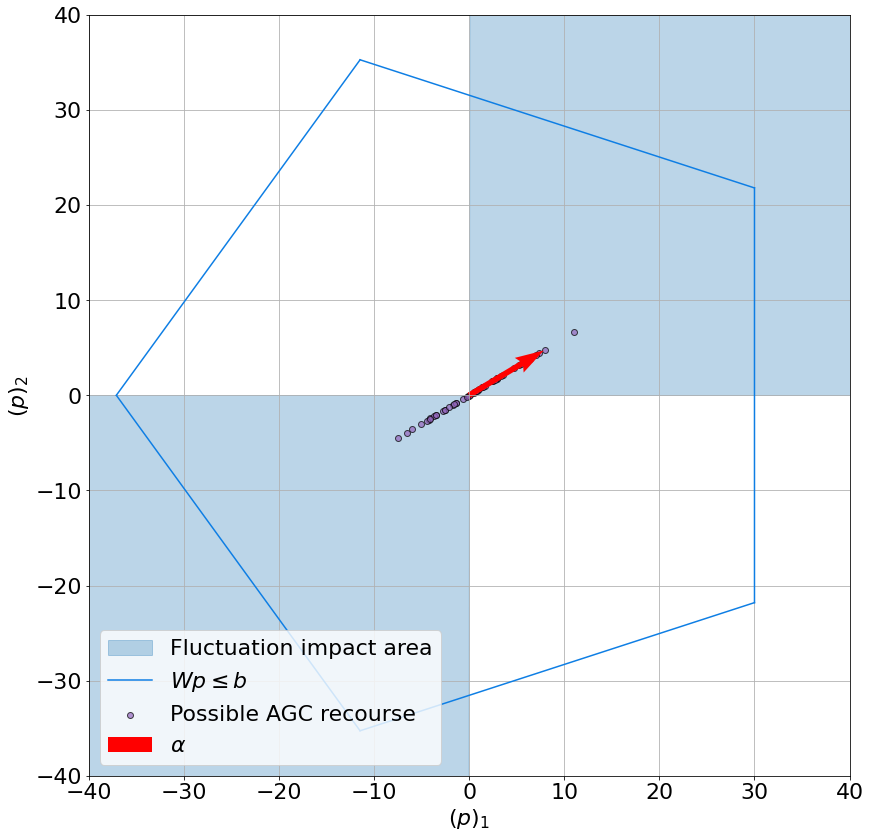

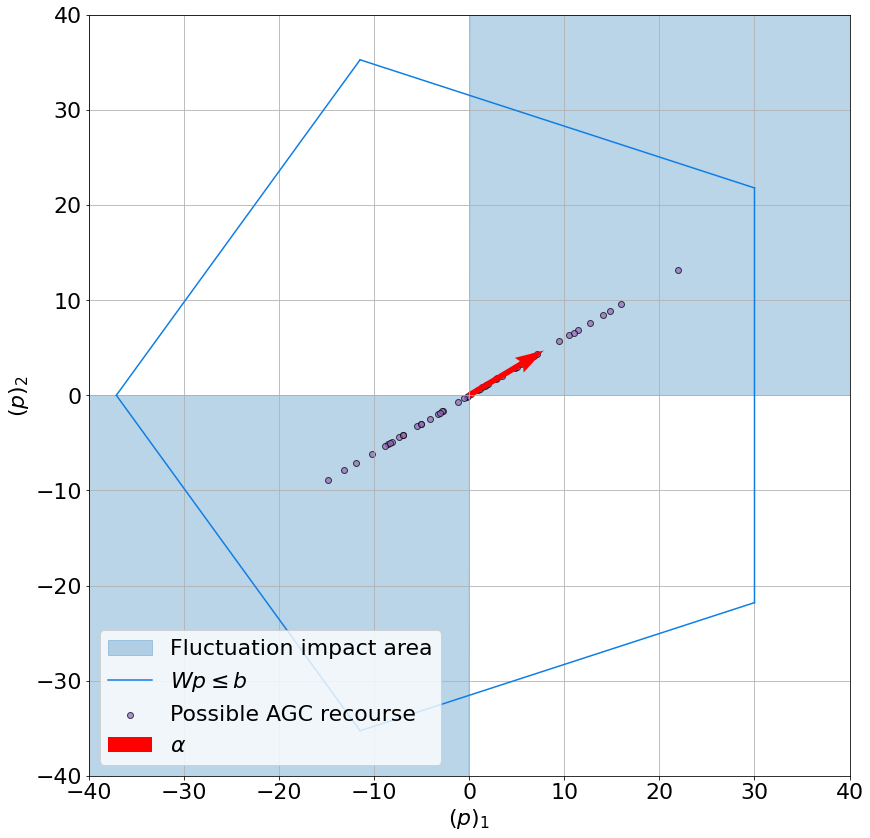

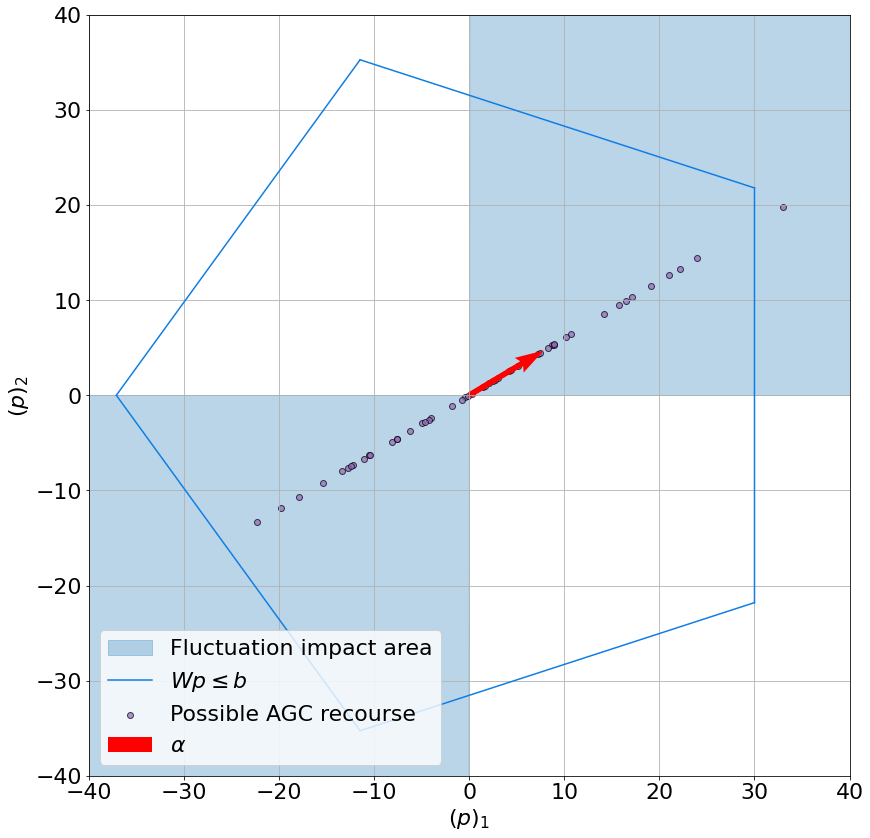

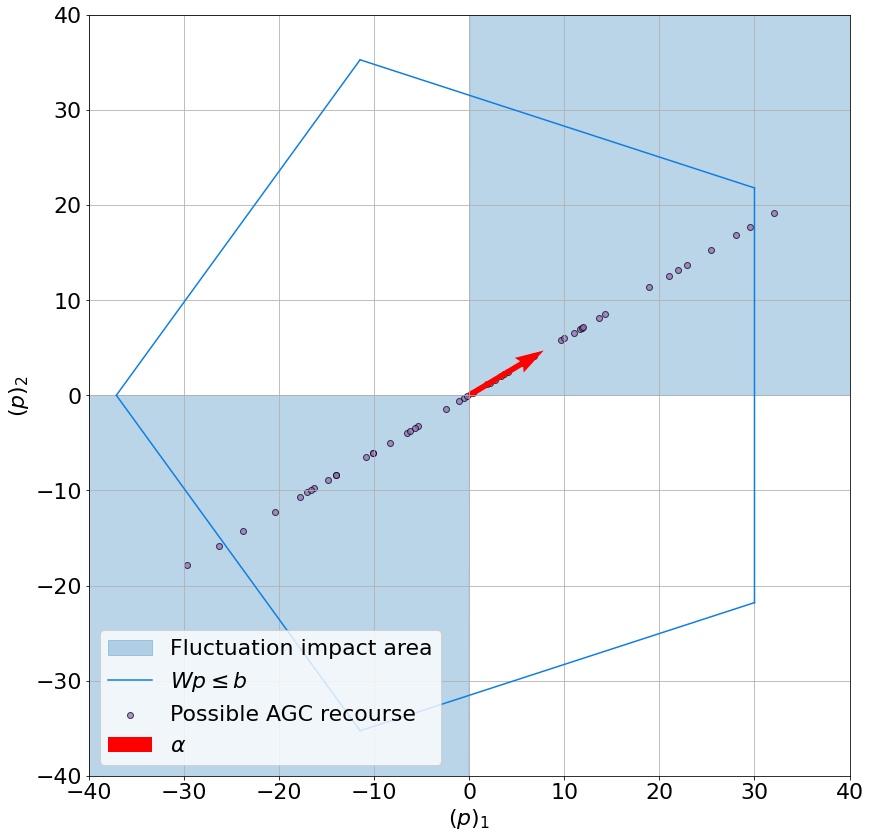

In [8]:
t = 0
# plt.figure()

# fig.suptitle('cock size increase with gachimixes listened')
# ax1.plot(x, y)
# ax2.plot(x, y**2, 'tab:orange')
# ax3.plot(x + 1, -y, 'tab:green')
# ax4.plot(x + 2, -y**2, 'tab:red')

x = np.array([0, 50, 50])
y = np.array([0, 50000, 50000])
def plot_quarter(ax1, sigma_=1, ax_i=1):
    ax1.fill_between(x, 0, y, where=y>0, interpolate=True, alpha=0.3, color='C0', label='Fluctuation impact area')
    ax1.fill_between(-x, 0, -y, where=y>0, interpolate=True, alpha=0.3, color='C0')
    plotting.plot_polygon(Gamma_snapshots[t], Beta_snapshots[t], label=r'$Wp \leq b$', xmin=-200, xmax=200, ax=ax1)
    # plotting.plot_polygon(Gamma_snapshots[t], Beta_P_snapshots[t], label='P_m', xmin=-200, xmax=200, color_idx=3)
    # plotting.plot_polygon(Gamma_snapshots[t], Beta_snapshots[t] - Beta_P_snapshots[t], label='P_in', xmin=-200, xmax=200, color_idx=6)


    V = np.array([[5,3], ])
    origin = np.array([[0],[0]]) # origin point

    
    np.random.seed(112)
    normal_samples = np.random.randn(50) * 1 * sigma_
    
    ax1.scatter(V[0][0] * normal_samples, V[0][1] * normal_samples, color='C4', alpha=0.7, edgecolors='black', label='Possible AGC recourse')
    ax1.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=51, label=r'$\alpha$')
    ax1.set_xlim((-40, 40))
    ax1.set_ylim((-40, 40))
    ax1.grid()
    
    
    ax1.set_xlabel(r'$(p)_1$')
    ax1.set_ylabel(r'$(p)_2$')

    # ax1.tight_layout()
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plot_quarter(ax, sigma_=1, ax_i=0)
plt.legend(prop={"size": font['size']}, loc="lower left")
plt.savefig('../saves/recourse_sigma1.png')
plt.show()


fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plot_quarter(ax, sigma_=2, ax_i=0)
plt.legend(prop={"size": font['size']}, loc="lower left")
plt.savefig('../saves/recourse_sigma2.png')
plt.show()

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plot_quarter(ax, sigma_=3, ax_i=0)
plt.legend(prop={"size": font['size']}, loc="lower left")
plt.savefig('../saves/recourse_sigma3.png')
plt.show()

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plot_quarter(ax, sigma_=4, ax_i=0)
plt.legend(prop={"size": font['size']}, loc="lower left")
plt.savefig('../saves/recourse_sigma4.png')
plt.show()
# for ax in fig.get_axes():
#     ax.label_outer()
# plt.savefig('../saves/poly_and_alpha.png')

# plotting.plot_polygon(A_snapshots[t], np.ones(J) * (Phi_inv), label='A xi <= Phi^-1(eta)', xmin=-200, xmax=200, color_idx=2)
# plotting.plot_polygon(A_snapshots[t], Beta_P_snapshots[t], label='step0 for xi', color_idx=4, xmin=-200, xmax=200)

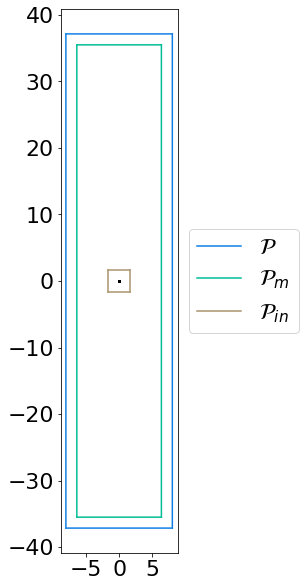

In [8]:
from scipy.stats import norm
eta = 0.05
A = np.array([[1, 0], [0, 0.7], [-1, 0], [0, -0.7]])
b = np.array([8, 26, 8, 26])
Delta = np.linalg.norm(A, axis=1) * norm.ppf(1-eta)
plt.figure(figsize=(10,10))
plotting.plot_polygon(A, b, label=r'$\mathcal{P}$', xmin=-200, xmax=200, color_idx=1)
plotting.plot_polygon(A, b - Delta, label=r'$\mathcal{P}_m$', xmin=-200, xmax=200, color_idx=2)
plotting.plot_polygon(A, Delta, label=r'$\mathcal{P}_{in}$', xmin=-200, xmax=200, color_idx=6)
# plotting.plot_polygon(A, b, label=r'$Wp \leq b$', xmin=-200, xmax=200)


In [ ]:
t = 0
plt.figure(figsize=(14, 14))
plotting.plot_polygon(Gamma_snapshots[t], Beta_snapshots[t], label=r'$Wp \leq b$', xmin=-200, xmax=200)
# plotting.plot_polygon(Gamma_snapshots[t], Beta_P_snapshots[t], label='P_m', xmin=-200, xmax=200, color_idx=3)
# plotting.plot_polygon(Gamma_snapshots[t], Beta_snapshots[t] - Beta_P_snapshots[t], label='P_in', xmin=-200, xmax=200, color_idx=6)
x = np.array([0, 50, 50])
y = np.array([0, 50000, 50000])
plt.fill_between(x, 0, y, where=y>0, interpolate=True, alpha=0.3, color='C0', label='Fluctuation impact area')
plt.fill_between(-x, 0, -y, where=y>0, interpolate=True, alpha=0.3, color='C0')

V = np.array([[5,3], ])
origin = np.array([[0],[0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=51, label=r'$\alpha$')
np.random.seed(112)
normal_samples = np.random.randn(500) * 30
# Pi_tau_sample, Delta_poly = sampling.get_sampling_poly(
#         Gamma, Beta, np.ones(len(alpha_0)), T, eta, sigmas_sq*30
#     )
Pi_tau_sample, Delta_poly = sampling.get_sampling_poly(
        Gamma, Beta, V[0] / sum(V[0]), T, 0.01, sigmas_sq*35
    )
samples_SAIMIN = (
            sampling.get_samples_SAIMIN(
                500, eta, len(Delta_poly), Pi_tau_sample, Delta_poly
            )
            * t_factors
        )
plt.scatter(V[0][0] * normal_samples, V[0][1] * normal_samples, color='C4', alpha=0.7, edgecolors='black', label='Possible AGC recourse')
plt.scatter(V[0][0] * samples_SAIMIN[:,0], V[0][1] * samples_SAIMIN[:,0], color='C12', alpha=0.9, edgecolors='black', label='Possible AGC recourse - IS')

plt.plot([0, (150+30*V[0][1]) / V[0][0]], [(150)/V[0][1] , -30], color='grey')
plt.plot([0, -(150+30*V[0][1]) / V[0][0]], [-(150)/V[0][1] , +30], color='grey')

plt.xlim((-40, 40))
plt.ylim((-40, 40))
plt.grid()
plt.legend(prop={"size": font['size']/1.5}, loc="upper left")
plt.xlabel(r'$(p)_1$')
plt.ylabel(r'$(p)_2$')
plt.tight_layout()

In [10]:
Delta_poly[:].max()

24.476757240468643

In [11]:
Pi_tau_sample, Delta_poly = sampling.get_sampling_poly(Gamma, Beta, alpha_0, T, eta, sigmas_sq)

In [12]:
# N = 400
ramp_up_down = np.array([5, 7])
delta_alpha = np.ones(Gamma.shape[1]) * 0.1
optimize_samples = True
# samples_SAIMIN = sampling.get_samples_SAIMIN(N, eta, len(Delta_poly), Pi_tau_sample, Delta_poly) * t_factors

In [13]:
ramp_up_down

array([5, 7])

In [14]:
x0 = np.hstack((np.zeros(Gamma.shape[1]), alpha_0))
# x_opt, prob_status = SU.solve_glpk(eqs, ineqs, x0, c)

# SCC (below are outdated notes)
Assume the system is standartized $\left(\chi \sim \mathcal{N}(0, I_n), ~ \| a_i \|_2 = 1\right)$
$$
\begin{aligned}
\mathbb{P} \Bigg\{ \forall ~ i ~ \gamma_i^\top x + &a_i^\top \chi \leq \beta_i \Bigg\} \geq 1 - \eta \\
&\Updownarrow \\
\mathbb{P} \Bigg\{ \bigcup_{i=1}^J ~ \gamma_i^\top x + &a_i^\top \chi > \beta_i \Bigg\} \leq  \eta
\end{aligned}
$$
Note that
$$
\mathbb{P} \Bigg\{ \bigcup_{i=1}^J ~ \gamma_i^\top x + a_i^\top \chi > \beta_i \Bigg\} \leq \sum_{i=1}^J \mathbb{P} \Bigg\{  \gamma_i^\top x + a_i^\top \chi > \beta_i \Bigg\}
$$
Due to the semi-additivity of measure $\mathbb{P}$. Thus, ensuring R.H.S. to be less thatn $\eta$, we ensure original probability to be less than $\eta$ -- conservative approximation.

In [31]:
x_scc, x_scc_status = AA.scc(x0, c, Gamma, Beta, alpha_0, ramp_up_down, delta_alpha, T, t_factors**2, (eta)/2)

Gamma_OOS, rhs_OOS, Pi_OOS = sampling.prepare_planes_OOS(x_scc.flatten(), Gamma, Beta, ramp_up_down, T)
scc_prob = check_feasibility_out_of_sample(x_scc.flatten(), Gamma_OOS, rhs_OOS, Pi_OOS, t_factors, 100000)
scc_prob

0.97392

# Solve several scenario approximations

## Estimation of probability of feasibility of approximation solution to be feasible for original problem
> 1. For each $N$ solve approximation $L$ times with different samples
> 2. Based on $L$ observations for solution of approximation with $N$ samples, estimate prob. of feasibility for original problem
> 3. Based on $L$ observations make box plots for ''conservativity'' - $\hat{\mathbb{P}}(x \texttt{ is feasible}) - \eta$

# **<font color='red'>Attention!</font>**
Setting $ L > 1 $ may lead to a long computational process!

In [47]:
# Store sigma and mu, next, the solutions for approximation will be pushed
results = {"Sigma": [[float(v) for v in row] for row in sigmas_sq], 
           "mu": [float(v) for v in mu]}
N0 = 2
ks = list(range(1, 55))[::5]
# ks = list(range(1, 15))[::5]
L = 40

In [48]:
for k in tqdm(ks):
    N = N0 * k
    print(k, "/", ks[-1])
    
    # with Pool() as pool:
    #     def call_solve():
    #         return SU.solve_approximations(Gamma, Beta, Pi_tau_sample, Delta_poly, t_factors**2, ramp_up_down, T, alpha_0, delta_alpha, N, c, eta, x0, True)
    #     results[N] = pool.starmap(func=call_solve, iterable=[(i, np.random.randn()) for i in range(L)])
    for l in range(L):
        res = SU.solve_approximations(Gamma, Beta, Pi_tau_sample, Delta_poly, t_factors**2, ramp_up_down, T, alpha_0, delta_alpha, N, c, eta, x0, True)
        
        try:
            results[N].append(res)
        except KeyError:
            results[N] = []
            results[N].append(res)

  0%|          | 0/11 [00:00<?, ?it/s]

1 / 51


/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/cvxpy/problems/problem.py:1302: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


6 / 51
11 / 51
16 / 51
21 / 51
26 / 51
31 / 51
36 / 51
41 / 51
46 / 51
51 / 51


# Unpack results (for one simulation) and plot them

In [49]:
save_dir = os.path.join("..", "saves", "synthetic")
json_file = os.path.join("J_" + str(J) + "_tau_" + str(tau) + "_N_" + str(N0 * ks[-1]) + ".json")

In [50]:
try:
    with open(os.path.join(save_dir, json_file), 'w') as fp:
        json.dump(results, fp, indent=4)
except FileNotFoundError:
    os.makedirs(save_dir)
    with open(os.path.join(save_dir, json_file), 'w') as fp:
        json.dump(results, fp, indent=4)

In [51]:
# load if necessary
# with open(os.path.join(save_dir, json_file), 'r') as fp:
#     results = json.load(fp)

Text(0, 0.5, 'Objective')

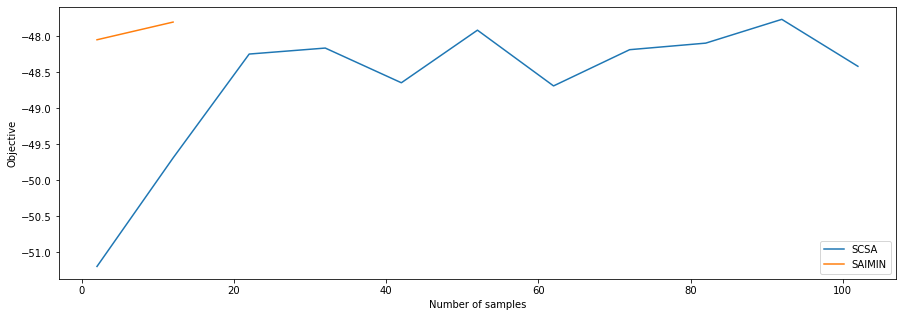

In [61]:
plt.figure(figsize=(15, 5))
def unpack_results(results, k=0):
    try:
        names = list(results[N0][k].keys())
    except KeyError:
        names = list(results[str(N0)][k].keys())
    fns = []
    xs = []
    for r in results.keys():
        if r not in ["Sigma", "mu"]:
            for v in results[r][k].values():
                try:
                    if len(v[0]) == 0:
                        xs.append(np.array([0] * A.shape[1] * 2))
                    else:
                        xs.append(v[0])
                    fns.append(np.dot(v[0], c))
                except ValueError:
                    fns.append(np.nan)
    fns = np.array(fns).reshape(-1, len(names))
    xs = np.array(xs).reshape(-1, len(names), A.shape[1] * 2)
    return fns, xs, names
fns, xs, names = unpack_results(results=results, k=1)
for i in range(fns.shape[1]):
    plt.plot(np.array(ks) * N0, fns[:, i], label=names[i])

# plt.hlines(y = [res_boole.fun], xmin = 0, xmax = ks[-1] * N0, label='Boole', color='black', linestyle='dotted')
plt.legend()
plt.xlabel("Number of samples")
plt.ylabel("Objective")

# Out of sample validation

In [64]:
# boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 100000)
# check_feasibility_out_of_sample(x_opt.flatten(), Gamma_OOS, rhs_OOS, Pi_OOS, 100000)
# Gamma_OOS, rhs_OOS, Pi_OOS = sampling.prepare_planes_OOS(x, Gamma, Beta, ramp_up_down, T)
scenario_probs = []
for i in range(len(names)):
    def check(x):
        Gamma_OOS, rhs_OOS, Pi_OOS = sampling.prepare_planes_OOS(x, Gamma, Beta, ramp_up_down, T)
        return check_feasibility_out_of_sample(x.flatten(), Gamma_OOS, rhs_OOS, Pi_OOS, t_factors, 100000)
    scenario_probs.append(np.apply_along_axis(arr=xs[:, i, :], func1d=lambda x: check(x), axis=1))
scenarios_probs = np.array(scenario_probs)

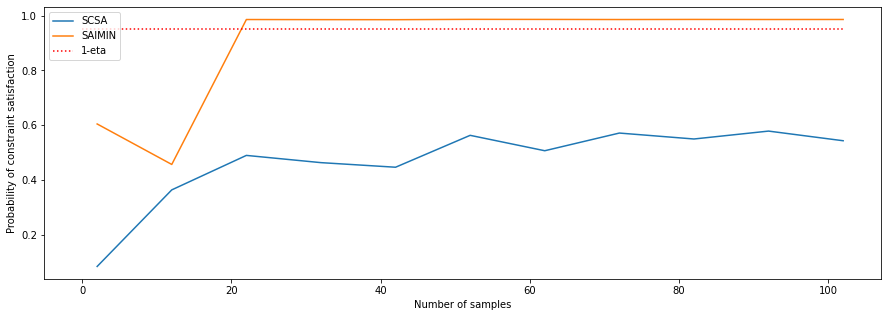

In [65]:
plt.figure(figsize=(15, 5))

for i in range(scenarios_probs.shape[0]):
    plt.plot(np.array(ks) * N0, scenarios_probs[i,:], label=names[i])

# plt.hlines(y = [boole_prob], xmin = 0, xmax = ks[-1] * N0, label='Boole', color='black', linestyle='dotted')
plt.hlines(y = [1-eta], xmin = 0, xmax = ks[-1] * N0, label='1-eta', color='red', linestyle='dotted')
plt.legend()
#plt.yscale('log')
#plt.ylim((1-eta-1e-2, 1 + 1e-4))
plt.xlabel("Number of samples")
plt.ylabel("Probability of constraint satisfaction")
plt.show()

# Plot results of multiple simulations
> 1. Estimates for probability of a solution of approximation to be feasible for original problem ($\beta$)
> 2. Box plots for estimates of probability of satisfying constraints

In [67]:
scenario_prob_estimate = np.zeros((len(names), len(ks)))
scenario_probs_several_starts = []
for k in tqdm(range(L)):
    _, xs, names = unpack_results(results=results, k=k)
    # boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 100000)
    def check(x):
        Gamma_OOS, rhs_OOS, Pi_OOS = sampling.prepare_planes_OOS(x, Gamma, Beta, ramp_up_down, T)
        return check_feasibility_out_of_sample(x.flatten(), Gamma_OOS, rhs_OOS, Pi_OOS, t_factors, 100000)
    scenarios_probs = np.array([np.apply_along_axis(arr=xs[:, i, :], func1d=lambda x: check(x), axis=1) for i in range(len(names))])
    scenario_prob_estimate += (scenarios_probs - eta >= 0.)
    scenario_probs_several_starts.append(scenarios_probs)
scenario_prob_esimate = scenario_prob_estimate / L
scenario_probs_several_starts = np.array(np.stack(scenario_probs_several_starts))

  0%|          | 0/40 [00:00<?, ?it/s]

In [68]:
pd_boxplot = pd.DataFrame({"N": [], "Method": [], "Prob_est - 1-eta": []})
for method_idx in range(scenario_probs_several_starts.shape[1]):
    data = scenario_probs_several_starts[:, method_idx, :]
    pd_boxplot_tmp = pd.DataFrame({"N": [], "Method": [], "Prob_est - 1-eta": []})
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            pd_boxplot_tmp = pd.concat([pd_boxplot_tmp, pd.DataFrame({"N": [ks[j] * N0], "Method": [names[method_idx]], "Prob_est - 1-eta": [data[i, j] - (1-eta)]})], ignore_index=True)
    pd_boxplot = pd.concat([pd_boxplot, pd_boxplot_tmp])

/var/folders/x3/2q_gzsqs643dbh4q2k13s0z80000gn/T/ipykernel_80803/3333476108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = (pdSeries_tmp["Prob_est - 1-eta"] > 0).values
/var/folders/x3/2q_gzsqs643dbh4q2k13s0z80000gn/T/ipykernel_80803/3333476108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = (pdSeries_tmp["Prob_est - 1-eta"] > 0).values


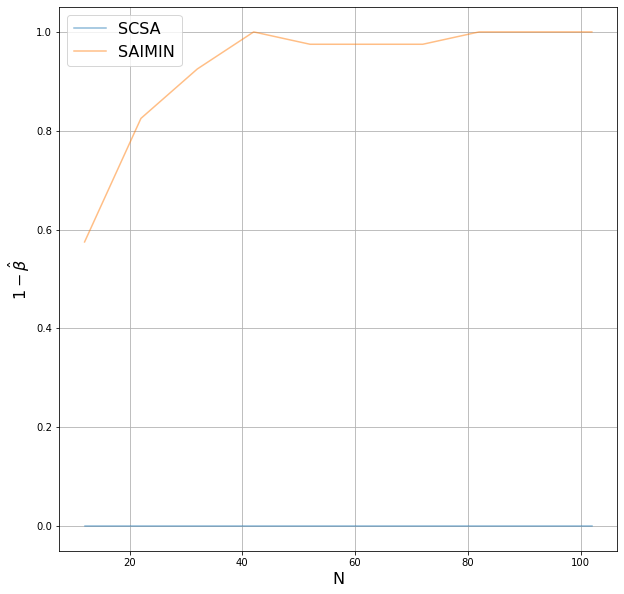

In [69]:
plt.figure(figsize=(10, 10))
fsize = 16
figure_path_1_beta = os.path.join(save_dir, "figures", "1_beta_J_" + str(J) + "_tau_" + str(tau) + "_N_" + str(N0 * ks[-1]) + ".png")
for i in range(len(names)):
    pdSeries_tmp = (pd_boxplot.loc[(pd_boxplot["Method"] == names[i]) & (pd_boxplot["N"] > 2)])
    #pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = pdSeries_tmp["Prob_est - 1-eta"].apply(lambda x: 1.0 if x >= 0 else 0.0)
    pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = (pdSeries_tmp["Prob_est - 1-eta"] > 0).values
    pdSeries_tmp = pdSeries_tmp.groupby("N").mean()
    x_plot = pdSeries_tmp.index
    y_plot = pdSeries_tmp["Prob_est - 1-eta"].values
    plt.plot(x_plot, y_plot, label=names[i], alpha=0.5)
    #plt.plot(np.array(ks)[1:] * N0, scenario_prob_esimate[i, 1:], label=names[i])
plt.xlabel("N", fontsize=fsize)
plt.ylabel(r"$1 - \hat{\beta}$", fontsize=fsize)
plt.grid()
plt.legend(prop={'size': fsize})
#plt.savefig(figure_path_1_beta)

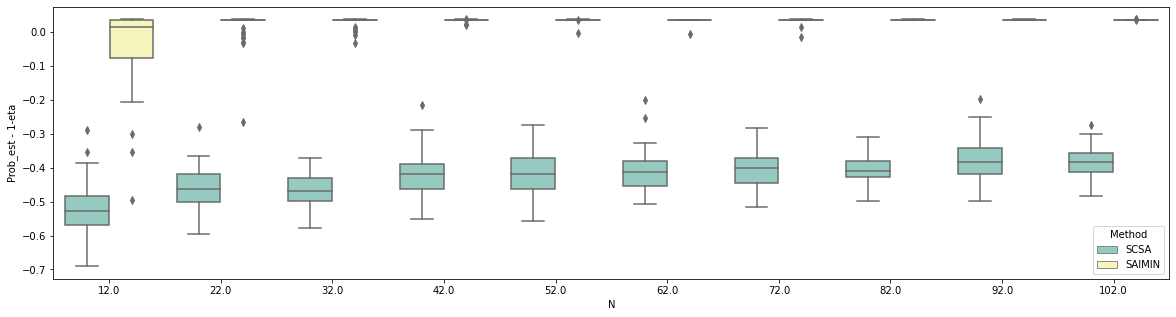

In [70]:
figure_path_box = os.path.join(save_dir, "figures", "boxplot_J_" + str(J) + "_tau_" + str(tau) + "_N_" + str(N0 * ks[-1]) + ".png")
plt.figure(figsize=(20, 5))
ax = sns.boxplot(x="N", y="Prob_est - 1-eta", hue="Method",
                 data=pd_boxplot[pd_boxplot["N"] > 6], palette="Set3")
# plt.ylim((-0.1, 0.1))
#plt.grid()
#plt.savefig(figure_path_box)